In [7]:
import arviz as az
import numpy as np
import pandas as pd
import stan
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nest_asyncio

In [8]:
# List of subjects
subList = ['sub-004', 'sub-020', 'sub-012', 'sub-020', 'sub-025', 'sub-026', 'sub-029',
           'sub-030', 'sub-033', 'sub-034', 'sub-036', 'sub-040', 'sub-041', 'sub-042',
           'sub-045', 'sub-047', 'sub-048', 'sub-052', 'sub-054', 'sub-056', 'sub-059',
           'sub-060', 'sub-064', 'sub-065', 'sub-067', 'sub-069', 'sub-070', 'sub-071'
           'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080',
           'sub-081', 'sub-082', 'sub-083', 'sub-085', 'sub-087', 'sub-088', 'sub-089',
           'sub-090', 'sub-092', 'sub-108', 'sub-109']
sub = subList[0]
# If you want to model fit or just recall ex model fit
modelFit = True
# Number of chains in MCMC procedure
n_chains = 10
# The number of iteration or samples for each chain in MCM procedure
n_samples=1000
# Name of subject
subName = sub
# Main directory of the subject
subMainDirec = '/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/'

"""Fitting data to model and then save as pickle file in the subject directory if modelFit = True"""
# List of existing .csv files for each session and run realted to the subject
files = ['/ses-02achieva7t/' + subName + '_ses-02achieva7t_task-DA_run-1_beh.csv',
         '/ses-02achieva7t/' + subName + '_ses-02achieva7t_task-DA_run-2_beh.csv',
         '/ses-03achieva7t/' + subName + '_ses-03achieva7t_task-DA_run-1_beh.csv',
         '/ses-03achieva7t/' + subName + '_ses-03achieva7t_task-DA_run-2_beh.csv']
# Making empty Dataframe to be concatenated for all four .csv file of the subject
data = pd.DataFrame([])
for i in range(len(files)):
    direc = subMainDirec + subName + files[i]
    df = pd.read_csv(direc)
    data = pd.concat([data, df])
# Detection of irregular responces (no-responses or error responces)
temp = data['pushed'].to_numpy().astype(int)
dataClear = data[temp>=0]
# Put required data for stan model
dataStan = {'N':int(dataClear.shape[0]),  
            'nCond':2, 
            'nSes':2, 
            'pushed':np.array(dataClear.pushed).astype(int),  
            'yellowChosen':np.array(dataClear.yellowChosen).astype(int), 
            'winAmtPushable':np.array(dataClear.winAmtPushable).astype(int), 
            'winAmtYellow':np.array(dataClear.winAmtYellow).astype(int), 
            'rewarded':np.array(dataClear.correctChoice).astype(int),       
            'session':np.array(dataClear.session).astype(int), 
            'cond':np.array(dataClear.block.replace('Act',1).replace('Stim',2)).astype(int),  
            'p_push_init':.5, 
            'p_yell_init':.5}

In [11]:
# Loading the RL Stan Model
file_name = 'stan_models/RL_indv_2.stan' 
file_read = open(file_name, 'r')
stan_model = file_read.read()
# Use nest-asyncio.This package is needed because Jupter Notebook blocks the use of certain asyncio functions
nest_asyncio.apply()
# Building Stan Model realted to our proposed model
posterior = stan.build(stan_model, data = dataStan)
# Start for taking samples from parameters in the Stan Model
fit = posterior.sample(num_chains=n_chains, num_samples=n_samples)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_gpm_dd60/model_ufzl4eue.stan', line 9, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gpm_dd60/model_ufzl4eue.stan', line 10, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_gpm_dd60/model_ufzl4eue.stan', line 11, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-form

  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampl

    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000675 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.75 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter is -nan, but must be in the interval [0, 1] (in '/tmp/httpstan_92xf_unc/model_ufzl4eue.stan', line 107, column 8 to column 46)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: bernoulli_lpmf: Probability parameter is -nan, but must be in the interval [0, 1] (in '/tmp/httpstan_92xf_unc/model_u

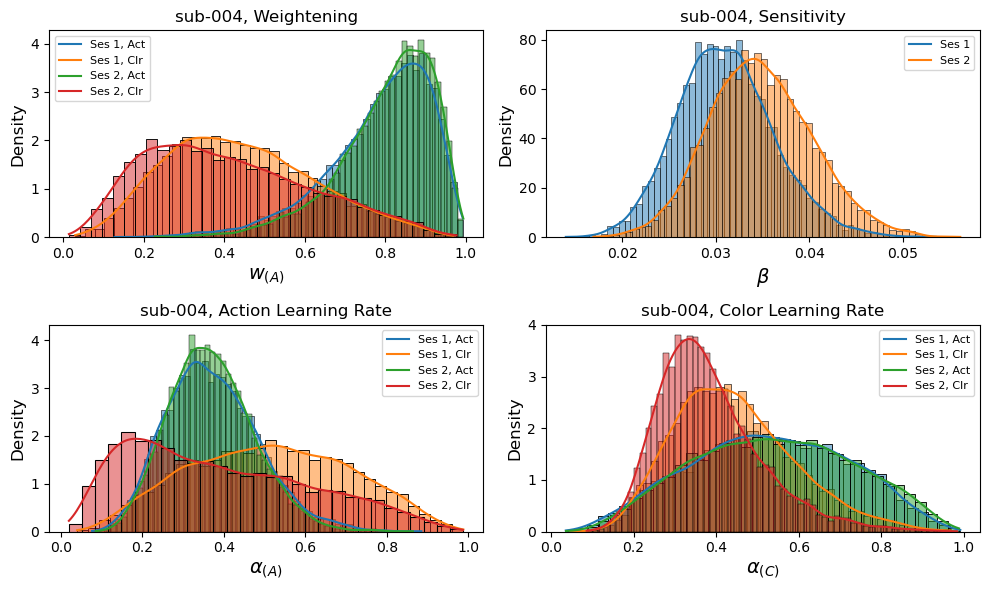

In [12]:
# Extracting posterior distributions for each of four main unkhown parameters
alphaAct_ = fit["transf_alphaAct"] 
alphaClr_ = fit["transf_alphaClr"] 
weightAct_ = fit["transf_weightAct"] 
beta_ = fit["transf_sensitivity"] 

# Figure of model fit results in two column and two rows
fig = plt.figure(figsize=(10, 6), tight_layout=True)
rows = 2
columns = 2

# Weghtening
fig.add_subplot(rows, columns, 1)
sns.histplot(weightAct_[0, 0], kde=True, stat='density')
sns.histplot(weightAct_[0, 1], kde=True, stat='density')
sns.histplot(weightAct_[1, 0], kde=True, stat='density')
sns.histplot(weightAct_[1, 1], kde=True, stat='density')
plt.title(subName + ', Weightening', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel('$w_{(A)}$', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)


# Sensitivity
fig.add_subplot(rows, columns, 2)
sns.histplot(beta_[0], kde=True, stat='density')
sns.histplot(beta_[1], kde=True, stat='density')
plt.title(subName + ', Sensitivity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$\beta$', fontsize=14)
plt.legend(['Ses 1', 'Ses 2'], fontsize=8)


# Action Learning Rate
fig.add_subplot(rows, columns, 3)
sns.histplot(alphaAct_[0, 0], kde=True, stat='density')
sns.histplot(alphaAct_[0, 1], kde=True, stat='density')
sns.histplot(alphaAct_[1, 0], kde=True, stat='density')
sns.histplot(alphaAct_[1, 1], kde=True, stat='density')
plt.title(subName + ', Action Learning Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$ \alpha_{(A)} $', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)

# Color Learning Rate
fig.add_subplot(rows, columns, 4)
sns.histplot(alphaClr_[0, 0], kde=True, stat='density')
sns.histplot(alphaClr_[0, 1], kde=True, stat='density')
sns.histplot(alphaClr_[1, 0], kde=True, stat='density')
sns.histplot(alphaClr_[1, 1], kde=True, stat='density')
plt.title(subName + ', Color Learning Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$ \alpha_{(C)} $', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)

plt.subplots_adjust(wspace=10.)

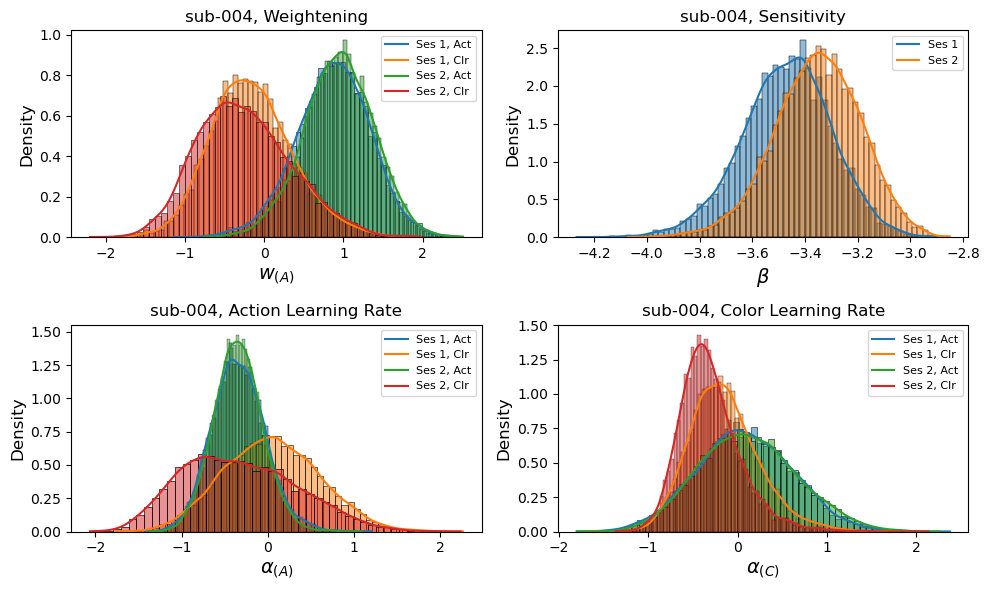

In [6]:
# Extracting posterior distributions for each of four main unkhown parameters
alphaAct_ = fit["alphaAct"] 
alphaClr_ = fit["alphaClr"] 
weightAct_ = fit["weightAct"] 
beta_ = fit["sensitivity"] 

# Figure of model fit results in two column and two rows
fig = plt.figure(figsize=(10, 6), tight_layout=True)
rows = 2
columns = 2

# Weghtening
fig.add_subplot(rows, columns, 1)
sns.histplot(weightAct_[0, 0], kde=True, stat='density')
sns.histplot(weightAct_[0, 1], kde=True, stat='density')
sns.histplot(weightAct_[1, 0], kde=True, stat='density')
sns.histplot(weightAct_[1, 1], kde=True, stat='density')
plt.title(subName + ', Weightening', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel('$w_{(A)}$', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)


# Sensitivity
fig.add_subplot(rows, columns, 2)
sns.histplot(beta_[0], kde=True, stat='density')
sns.histplot(beta_[1], kde=True, stat='density')
plt.title(subName + ', Sensitivity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$\beta$', fontsize=14)
plt.legend(['Ses 1', 'Ses 2'], fontsize=8)


# Action Learning Rate
fig.add_subplot(rows, columns, 3)
sns.histplot(alphaAct_[0, 0], kde=True, stat='density')
sns.histplot(alphaAct_[0, 1], kde=True, stat='density')
sns.histplot(alphaAct_[1, 0], kde=True, stat='density')
sns.histplot(alphaAct_[1, 1], kde=True, stat='density')
plt.title(subName + ', Action Learning Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$ \alpha_{(A)} $', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)

# Color Learning Rate
fig.add_subplot(rows, columns, 4)
sns.histplot(alphaClr_[0, 0], kde=True, stat='density')
sns.histplot(alphaClr_[0, 1], kde=True, stat='density')
sns.histplot(alphaClr_[1, 0], kde=True, stat='density')
sns.histplot(alphaClr_[1, 1], kde=True, stat='density')
plt.title(subName + ', Color Learning Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlabel(r'$ \alpha_{(C)} $', fontsize=14)
plt.legend(['Ses 1, Act', 'Ses 1, Clr', 'Ses 2, Act', 'Ses 2, Clr'], fontsize=8)

plt.subplots_adjust(wspace=10.)